# Imports


In [14]:
import tensorboard
import matplotlib.pyplot as plot
import statistics
from DatasetFormatting import *
import tensorflow.keras.layers.experimental.preprocessing as preprocessing
import numpy as np
import tensorflow.keras.layers as Layer
import tensorflow as tf
import pandas as pd
%load_ext tensorboard
from sklearn.model_selection import train_test_split
import sklearn.naive_bayes as NB


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Preparing Training Dataset


STD: 0.9976277124059775
mean: 6.165617412034789
variance: 0.9952610525603838
mode: 6.5
x_train shape: (16989,)


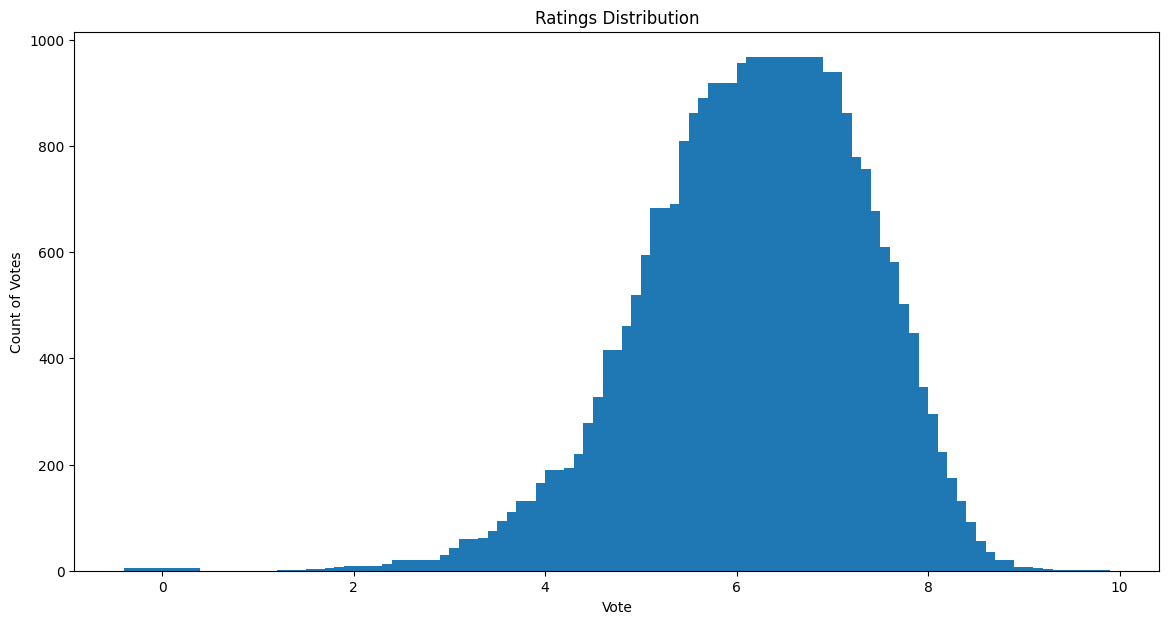

In [15]:
np.random.seed(1)
tf.random.set_seed(1)

movie_df = getData()
movie_df.drop(['vote_count'], axis=1)

data_count = movie_df.shape[0]
training_data_count = int(data_count * 0.75) + 1
test_data_count = data_count - training_data_count

y_train = np.array(movie_df['vote_average'].head(training_data_count))
x_train = np.array(movie_df['training_col'].head(training_data_count))

y_test = np.array(movie_df['vote_average'].tail(test_data_count))
x_test = np.array(movie_df[['training_col']].tail(test_data_count))

std = statistics.stdev(movie_df['vote_average'].to_list())
mean = statistics.mean(movie_df['vote_average'].to_list())
variance = statistics.variance(movie_df['vote_average'].to_list())
mode = statistics.mode(movie_df['vote_average'].to_list())

print(f"STD: {std}")
print(f"mean: {mean}")
print(f"variance: {variance}")
print(f"mode: {mode}")

# print(x_train)
print(f"x_train shape: {x_train.shape}")

plot.figure(figsize=[14, 7])
scores = movie_df['vote_average'].to_list()
unique, counts = np.unique(scores, return_counts=True)
plot.bar(unique, counts)
plot.title("Ratings Distribution")
plot.xlabel("Vote")
plot.ylabel("Count of Votes")

plot.show()


### Text Vectorization For Actors & Genres


In [16]:
VOCAB_SIZE = 201277
encoder = preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE, output_sequence_length=6)
features = np.array(movie_df['training_col'])
encoder.adapt(features)

# this line of code doesnt work on windows for some reason
# print(np.array(encoder.get_vocabulary()))


2023-06-27 22:04:06.139049: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


### Text Vectorization Sanity Check


In [17]:
print(movie_df['training_col'].to_numpy()[0])
x = encoder(movie_df['training_col'].to_numpy()[0]).numpy()
x


Horror DakotaFanning JosePabloCantillo


array([   5,  325, 3016,    0,    0,    0])

<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>

# Feed Forward Neural Network


### Building The FFNN


In [18]:
model_FFNN = tf.keras.Sequential([
    encoder,
    Layer.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=500),
    Layer.Flatten(input_shape=(16989, 1)),
    Layer.Dense(56, activation='tanh'),
    Layer.Dense(125, activation='tanh'),
    Layer.Dense(104, activation='tanh'),
    Layer.Dense(120, activation='tanh'),
    Layer.Dense(1)
])

model_FFNN.summary()

model_FFNN.compile(loss=tf.keras.losses.MeanSquaredError(),
                   optimizer=tf.keras.optimizers.RMSprop(.001))


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 6)                0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, 6, 500)            20632500  
                                                                 
 flatten_1 (Flatten)         (None, 3000)              0         
                                                                 
 dense_9 (Dense)             (None, 56)                168056    
                                                                 
 dense_10 (Dense)            (None, 125)               7125      
                                                                 
 dense_11 (Dense)            (None, 104)               13104     
                                                      

### Training The FFNN


Epoch 1/9


2023-06-27 22:04:07.329196: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - 3s 33ms/step - loss: 2.6879
Epoch 2/9
67/67 [==============================] - 2s 23ms/step - loss: 0.6116
Epoch 3/9
67/67 [==============================] - 1s 20ms/step - loss: 0.3662
Epoch 4/9
67/67 [==============================] - 1s 20ms/step - loss: 0.2440
Epoch 5/9
67/67 [==============================] - 1s 20ms/step - loss: 0.1872
Epoch 6/9
67/67 [==============================] - 1s 19ms/step - loss: 0.1521
Epoch 7/9
67/67 [==============================] - 1s 19ms/step - loss: 0.1272
Epoch 8/9
67/67 [==============================] - 1s 19ms/step - loss: 0.1141
Epoch 9/9
 21/177 [==>...........................] - ETA: 0s - loss: 0.7199

2023-06-27 22:04:20.508412: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


177/177 [==============================] - 1s 4ms/step - loss: 0.7518
Test loss: 0.7518441677093506


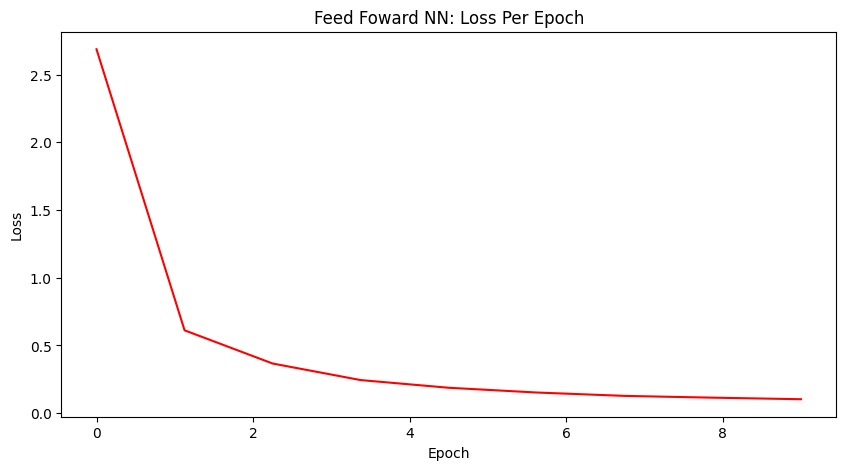

In [19]:
history = model_FFNN.fit(
    x_train,
    y_train,
    batch_size=256,
    epochs=9,
    verbose=1)

score = model_FFNN.evaluate(x_test, y_test)
print('Test loss:', score)
loss_history = history.history['loss']
plot.figure(figsize=[10, 5])
iterations, = plot.plot(np.linspace(
    0, len(loss_history), len(loss_history)), loss_history, color='red')
plot.title("Feed Foward NN: Loss Per Epoch")
plot.xlabel("Epoch")
plot.ylabel("Loss")
plot.show()


### Validating FFNN On **Train** Data


In [20]:
def print_train_prediction_ffnn(index):
    print(f"Prediction for index: {index}")

    print(f"input ---> {x_train[index]}")
    print(f"actual output ---> {y_train[index]}")
    print(f"predicted output ---> {model_FFNN.predict(x_test[index])}\n")


print_train_prediction_ffnn(0)
print_train_prediction_ffnn(3)
print_train_prediction_ffnn(4)


Prediction for index: 0
input ---> Horror DakotaFanning JosePabloCantillo
actual output ---> 7.2


1/1 [==============================] - 0s 83ms/step
predicted output ---> [[6.6977224]]

Prediction for index: 3
input ---> Action SigourneyWeaver EugeneKhumbanyiwa RobertHobbs CarlyPope BrandonAuret
actual output ---> 7.4
1/1 [==============================] - 0s 14ms/step
predicted output ---> [[6.5758476]]

Prediction for index: 4
input ---> Action AdriannePalicki MichaelJaiWhite TyOlsson PascaleHutton SamJaeger
actual output ---> 5.2
1/1 [==============================] - 0s 11ms/step
predicted output ---> [[5.9196234]]



2023-06-27 22:04:21.467281: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


### Validating FFNN On **Test** Data


In [21]:
def print_test_prediction_ffnn(index):
    print(f"Prediction for index: {index}")

    print(f"input ---> {x_test[index]}")
    print(f"actual output ---> {y_test[index]}")
    print(f"predicted output ---> {model_FFNN.predict(x_test[index])}\n")


print_test_prediction_ffnn(0)
print_test_prediction_ffnn(3)
print_test_prediction_ffnn(4)


Prediction for index: 0
input ---> ['Drama DannyGlover RonPerlman LindaHamilton ZoeWeizenbaum DavidStrathairn']
actual output ---> 6.1
1/1 [==============================] - 0s 11ms/step
predicted output ---> [[6.6977224]]

Prediction for index: 3
input ---> ['Drama PaulWalker PiperPerabo LambertWilson LindaCardellini ShawnHatosy']
actual output ---> 6.0


1/1 [==============================] - 0s 15ms/step
predicted output ---> [[6.5758476]]

Prediction for index: 4
input ---> ['Comedy MollyShannon WillFerrell ElaineHendrix HarlandWilliams TomGreen']
actual output ---> 5.0
1/1 [==============================] - 0s 13ms/step
predicted output ---> [[5.9196234]]



<br><br><br><br><br><br><br><br><br><br>


<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>
# Recurrent Neural Network


### Building The RNN


In [22]:
model_RNN = tf.keras.Sequential([
    encoder,
    Layer.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=450),
    Layer.SimpleRNN(200, activation='relu'),
    Layer.Dense(60, activation='relu'),
    Layer.Dense(20, activation='relu'),
    Layer.Dense(60, activation='relu'),
    # Layer.Dense(80, activation='relu'),
    Layer.Dense(1)
])

# model_RNN.summary()

model_RNN.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.RMSprop(.002))


### Training The RNN


Epoch 1/10


2023-06-27 22:04:22.465214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


34/34 [==============================] - 4s 88ms/step - loss: 21.9029
Epoch 2/10
34/34 [==============================] - 2s 72ms/step - loss: 2.9726
Epoch 3/10
34/34 [==============================] - 2s 66ms/step - loss: 4.2467
Epoch 4/10
34/34 [==============================] - 2s 69ms/step - loss: 2.9049
Epoch 5/10
34/34 [==============================] - 2s 67ms/step - loss: 2.2292
Epoch 6/10
34/34 [==============================] - 2s 65ms/step - loss: 1.6573
Epoch 7/10
34/34 [==============================] - 2s 64ms/step - loss: 1.3188
Epoch 8/10
34/34 [==============================] - 2s 61ms/step - loss: 1.0051
Epoch 9/10
34/34 [==============================] - 2s 60ms/step - loss: 0.8342
Epoch 10/10
  5/177 [..............................] - ETA: 2s - loss: 1.7645 

2023-06-27 22:04:46.049635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


177/177 [==============================] - 2s 10ms/step - loss: 2.3617
Test loss: 2.361692190170288


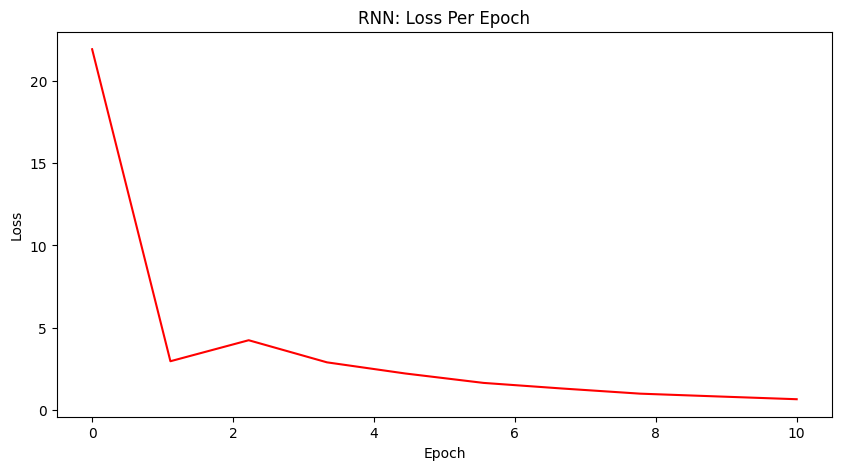

In [23]:
history = model_RNN.fit(
    x_train,
    y_train,
    batch_size=512,
    epochs=10,
    verbose=1)

score = model_RNN.evaluate(x_test, y_test)
print('Test loss:', score)

loss_history = history.history['loss']
plot.figure(figsize=[10, 5])
iterations, = plot.plot(np.linspace(
    0, len(loss_history), len(loss_history)), loss_history, color='red')
plot.title("RNN: Loss Per Epoch")
plot.xlabel("Epoch")
plot.ylabel("Loss")
plot.show()


### Validating RNN On **Train** Data


In [24]:
def print_train_prediction_rnn(index):
    print(f"Prediction for index: {index}")

    print(f"input ---> {x_train[index]}")
    print(f"actual output ---> {y_train[index]}")
    print(f"predicted output ---> {model_RNN.predict(x_test[index])}\n")


print_train_prediction_rnn(0)
print_train_prediction_rnn(3)
print_train_prediction_rnn(4)


Prediction for index: 0
input ---> Horror DakotaFanning JosePabloCantillo
actual output ---> 7.2


1/1 [==============================] - 0s 155ms/step
predicted output ---> [[5.894125]]

Prediction for index: 3
input ---> Action SigourneyWeaver EugeneKhumbanyiwa RobertHobbs CarlyPope BrandonAuret
actual output ---> 7.4
1/1 [==============================] - 0s 26ms/step
predicted output ---> [[5.4895706]]

Prediction for index: 4
input ---> Action AdriannePalicki MichaelJaiWhite TyOlsson PascaleHutton SamJaeger
actual output ---> 5.2
1/1 [==============================] - 0s 21ms/step
predicted output ---> [[4.6052313]]



2023-06-27 22:04:48.014751: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


### Validating RNN On **Test** Data


In [25]:
def print_test_prediction_rnn(index):
    print(f"Prediction for index: {index}")

    print(f"input ---> {x_test[index]}")
    print(f"actual output ---> {y_test[index]}")
    print(f"predicted output ---> {model_RNN.predict(x_test[index])}\n")


print_test_prediction_rnn(0)
print_test_prediction_rnn(3)
print_test_prediction_rnn(4)


Prediction for index: 0
input ---> ['Drama DannyGlover RonPerlman LindaHamilton ZoeWeizenbaum DavidStrathairn']
actual output ---> 6.1
1/1 [==============================] - 0s 22ms/step
predicted output ---> [[5.894125]]

Prediction for index: 3
input ---> ['Drama PaulWalker PiperPerabo LambertWilson LindaCardellini ShawnHatosy']
actual output ---> 6.0
1/1 [==============================] - 0s 19ms/step
predicted output ---> [[5.4895706]]

Prediction for index: 4
input ---> ['Comedy MollyShannon WillFerrell ElaineHendrix HarlandWilliams TomGreen']
actual output ---> 5.0
1/1 [==============================] - 0s 16ms/step
predicted output ---> [[4.6052313]]



<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>

# Niave Bayes Model


[ 4 10 11 12 13 14]
7
7
Total Correct Ratio: 14759/16989
0.8687385955618341


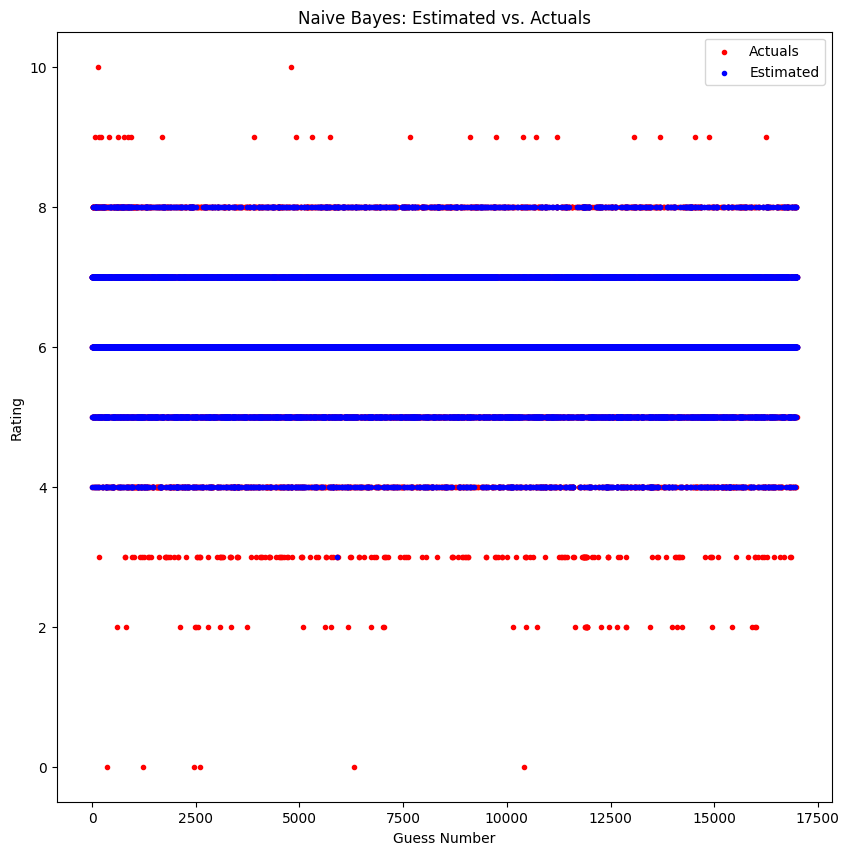

In [26]:
def naiveBayes(X, y):
    NBmodel = NB.CategoricalNB()
    NBmodel = NBmodel.fit(X, y)
    return NBmodel


def prepareForNB(data):
    all_actors = data['cast'].to_list()
    genres = data['genres'].to_list()

    X = []
    unique_keys = {'': 0}
    unique_key = 1

    for i in range(0, len(all_actors)):
        row = []

        raw_row = all_actors[i].split()
        raw_row.insert(0, genres[i])
        if len(raw_row) < 6:
            for i in range(0, 6 - len(raw_row)):
                raw_row.append('')

        for item in raw_row:
            if item not in unique_keys:
                unique_keys[item] = unique_key
                unique_key += 1
            row.append(unique_keys[item])

        X.append(row)

    genres = data['genres'].to_list()

    ratings = data['vote_average'].to_list()
    for i in range(0, len(ratings)):
        ratings[i] = round(ratings[i])

    return X, ratings


X, ratings = prepareForNB(movie_df)

data_count = movie_df.shape[0]
training_data_count = int(data_count * 0.75) + 1
test_data_count = data_count - training_data_count

nb_y_train = np.array(ratings[0:training_data_count])
nb_x_train = np.array(X[0:training_data_count])

nb_y_test = np.array(ratings[:-1 * test_data_count])
nb_x_test = np.array(X[:-1 * test_data_count])

NBmodel = naiveBayes(nb_x_train, nb_y_train)

y_pred = NBmodel.predict(nb_x_test)

print(nb_x_test[2])
print(nb_y_test[2])
print(y_pred[3])


total_correct = 0
for i in range(0, nb_y_test.shape[0]):
    if int(y_pred[i]) == nb_y_test[i]:
        total_correct += 1

test_size = nb_y_test.shape[0]
accuracy = total_correct/test_size
print(f"Total Correct Ratio: {total_correct}/{nb_y_test.shape[0]}")
print(accuracy)

plot.figure(figsize=[10, 10])
actuals = plot.scatter(np.linspace(0, test_size, test_size),
                       nb_y_test, color='red', marker='.')
estimates = plot.scatter(np.linspace(
    0, test_size, test_size), y_pred, color='blue', marker='.')
plot.legend([actuals, estimates], ["Actuals", "Estimated"])
plot.title("Naive Bayes: Estimated vs. Actuals")
plot.xlabel("Guess Number")
plot.ylabel("Rating")
plot.show()
